In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds

# **Preprocess the data**

1. Create subword data and tokernize
2. Replace sentence data with encoded subwords
3. Pad the sequences

In [3]:
data = pd.read_csv('combined_data.csv')
sentences = data['text'].tolist()
labels = data['sentiment'].tolist()

In [5]:
# Print some example sentences and labels
for x in range(5):
  print(sentences[x])
  print(labels[x])
  print("\n")

So there is no way for me to plug it in here in the US unless I go by a converter.
0


Good case Excellent value.
1


Great for the jawbone.
1


Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!
0


The mic is great.
1




In [6]:
vocab_size = 1000
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)
print("Vocab size is ", tokenizer.vocab_size)

Vocab size is  999


In [9]:
print(sentences[6])
encoded = tokenizer.encode(sentences[6])
print(encoded)
print("Length is: ", len(encoded))

If you have several dozen or several hundred contacts then imagine the fun of sending each of them one by one.
[364, 39, 31, 69, 500, 775, 197, 293, 38, 117, 69, 500, 775, 399, 123, 475, 775, 79, 62, 86, 3, 506, 241, 683, 557, 775, 1, 429, 38, 15, 69, 123, 26, 210, 232, 15, 507, 80, 361, 478, 789]
Length is:  41


In [10]:
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

If 
you 
have 
se
veral
 
do
ze
n 
or 
se
veral
 
hu
nd
red
 
con
ta
ct
s 
then 
im
ag
ine
 
the 
fu
n 
of 
se
nd
ing 
ea
ch 
of 
them 
one 
by 
one
.


In [11]:
# Replace sentence data with subword which equivalent to text_to_sequences with the Tokenizer
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [13]:
print(sentences[0])

[736, 168, 775, 7, 193, 417, 17, 94, 6, 600, 438, 775, 14, 19, 141, 19, 1, 828, 826, 775, 99, 445, 4, 174, 361, 5, 79, 227, 139, 789]


In [14]:
max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sequences
sequences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sequences = sequences_padded[0:training_size]
testing_sequences = sequences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [15]:
embedding_dim = 16

model = tf.keras.Sequential([
    # the input dimension is the vocab size 1000, embedding dimension is the output size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [22]:
num_epochs = 50
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, validation_data=(testing_sequences, testing_labels_final))

Epoch 1/50
50/50 [==============================] - 0s 5ms/step - loss: 0.1060 - accuracy: 0.9768 - val_loss: 0.7929 - val_accuracy: 0.7544
Epoch 2/50
50/50 [==============================] - 0s 4ms/step - loss: 0.1015 - accuracy: 0.9768 - val_loss: 0.7868 - val_accuracy: 0.7594
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0987 - accuracy: 0.9749 - val_loss: 0.8155 - val_accuracy: 0.7594
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0948 - accuracy: 0.9787 - val_loss: 0.8483 - val_accuracy: 0.7544
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0917 - accuracy: 0.9793 - val_loss: 0.8383 - val_accuracy: 0.7544
Epoch 6/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0895 - accuracy: 0.9799 - val_loss: 0.8575 - val_accuracy: 0.7544
Epoch 7/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0863 - accuracy: 0.9793 - val_loss: 0.8764 - val_accuracy: 0.7519
Epoch 8/50
50/50 [==

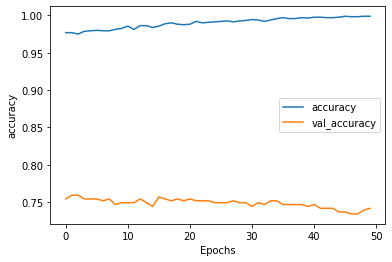

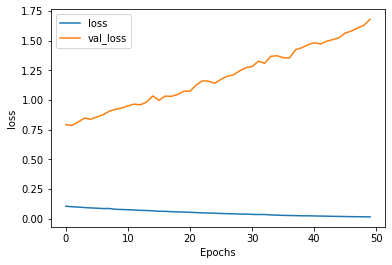

In [23]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Seem like overfitting, thus, we can add bias to reduce overfitting.

# **Predict the sentiment of reviews**

In [24]:
def predict_review(model, new_sentences, maxlen=max_length, show_padded_sequence=True ):
  # Keep the original sentences so that we can keep using them later
  # Create an array to hold the encoded sequences
  new_sequences = []

  # Convert the new reviews to sequences
  for i, frvw in enumerate(new_sentences):
    new_sequences.append(tokenizer.encode(frvw))

  trunc_type='post' 
  padding_type='post'

  # Pad all sequences for the new reviews
  new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)             

  classes = model.predict(new_reviews_padded)

  # The closer the class is to 1, the more positive the review is
  for x in range(len(new_sentences)):
    
    # We can see the padded sequence if desired
    # Print the sequence
    if (show_padded_sequence):
      print(new_reviews_padded[x])
    # Print the review as text
    print(new_sentences[x])
    # Print its predicted class
    print(classes[x])
    print("\n")

In [25]:
# some revies for test the model prediction
test_reviews = ["I like pure chocolate", 
                "The restaurant is full of smoke",
                "The cheese is smelly", 
                "The weather is so hot and causing children sweat", 
                "The milk taste is bad",
                "He do not cook in working day", 
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]

In [26]:
predict_review(model, test_reviews)

[  4  65 336 229 569 547 147 319   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I like pure chocolate
[0.03630694]


[ 13 329 347 775   7 357  37  15 309 443 844   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
The restaurant is full of smoke
[0.42346954]


[ 13 124  60  12   7 309 133 298   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
The cheese is smelly
[0.00386051]


[ 13  93 106 315   7  42 109   8   2 125 265  26 287 851 244 454 858  93
 106   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
The weather is so hot and causing children sweat
[0.00197804]




In [27]:
def fit_model_now (model, sentences) :
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, 
                      validation_data=(testing_sequences, testing_labels_final))
  return history

def plot_results (history):
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")

def fit_model_and_show_results (model, sentences):
  history = fit_model_now(model, sentences)
  plot_results(history)
  predict_review(model, sentences)

# **Add a regulization**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
50/50 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.5330 - val_loss: 0.6960 - val_accuracy: 0.4185
Epoch 2/50
50/50 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.5317 - val_loss

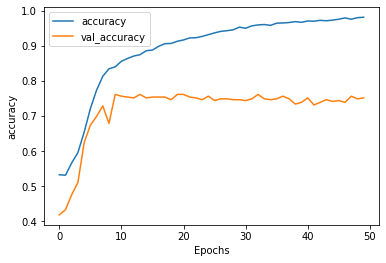

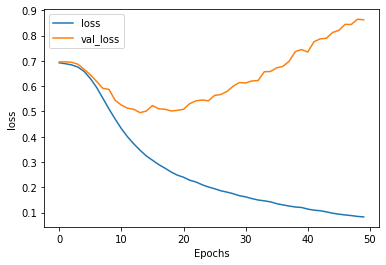

[  4  65 336 229 569 547 147 319   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I like pure chocolate
[0.06935905]


[ 13 329 347 775   7 357  37  15 309 443 844   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
The restaurant is full of smoke
[0.3238898]


[ 13 124  60  12   7 309 133 298   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
The cheese is smelly
[0.03449515]


[ 13  93 106 315   7  42 109   8   2 125 265  26 287 851 244 454 858  93
 106   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
The weather is so hot and causing children sweat
[0.00265622]


[

In [29]:
regularized_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(6, activation='relu', use_bias=True),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and train the model and then show the predictions for our extra sentences
fit_model_and_show_results(regularized_model, test_reviews)

# **Add bidirectional LSTM layer**

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                4224      
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 20,429
Trainable params: 20,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
50/50 [==============================] - 1s 22ms/step - loss: 0.6903 - accuracy: 0.5154 - val_loss: 0.6897 - val_accuracy: 0.5288
Epoch 2/50
50/50 [==============================] - 0s 9ms/step - loss: 0.6505 - accuracy: 0.6497 - val_los

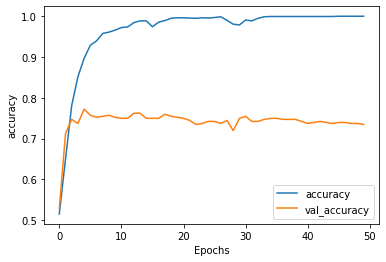

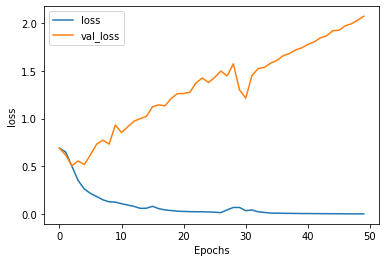

[  4  65 336 229 569 547 147 319   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I like pure chocolate
[0.00164544]


[ 13 329 347 775   7 357  37  15 309 443 844   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
The restaurant is full of smoke
[0.00175365]


[ 13 124  60  12   7 309 133 298   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
The cheese is smelly
[2.555457e-05]


[ 13  93 106 315   7  42 109   8   2 125 265  26 287 851 244 454 858  93
 106   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
The weather is so hot and causing children sweat
[3.4271598e-0

In [30]:
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(6, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and train the model and then show the predictions for our extra sentences
fit_model_and_show_results(model_bidi_lstm, test_reviews)